# DEEP LEARNING - PROJECT 1


## 0️⃣ Instalación de Dependencias

In [36]:
!pip install tensorflow scikit-learn pandas matplotlib seaborn -q

In [37]:

import gc


SAMPLE_FRACTION = 0.2

print(f'Configuración: se usará el {SAMPLE_FRACTION*100:.0f}% del dataset para ahorrar RAM')
print('Si el error de RAM persiste, reduce SAMPLE_FRACTION a 0.3 o menos')

Configuración: se usará el 20% del dataset para ahorrar RAM
Si el error de RAM persiste, reduce SAMPLE_FRACTION a 0.3 o menos


## 📦 Importación de Librerías

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

import warnings
warnings.filterwarnings('ignore')

# Semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Librerías cargadas correctamente ✅")

TensorFlow version: 2.19.0
Librerías cargadas correctamente ✅


---
## 1️⃣ Carga del Dataset

In [39]:
from google.colab import files
import io

uploaded = files.upload()

if not uploaded:
    raise ValueError('❌ No se subió ningún archivo. Por favor sube el CSV del dataset.')

filename = list(uploaded.keys())[0]
print(f'Archivo cargado: {filename}')

# Intentar diferentes separadores y encodings
for sep in [';', ',', '\t']:
    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin-1', sep=sep)
        if df.shape[1] > 1:
            print(f'Separador detectado: "{sep}"')
            break
    except Exception:
        continue

print(f'Dataset cargado: {df.shape[0]} filas × {df.shape[1]} columnas')
df.head()

Saving Dataset_ExamenesLaboratorio_ConsultaExterna_PatologíasRelacionadas_Obesidad_202405_202411 (1).csv to Dataset_ExamenesLaboratorio_ConsultaExterna_PatologíasRelacionadas_Obesidad_202405_202411 (1) (1).csv
Archivo cargado: Dataset_ExamenesLaboratorio_ConsultaExterna_PatologíasRelacionadas_Obesidad_202405_202411 (1) (1).csv
Separador detectado: ";"
Dataset cargado: 63799 filas × 28 columnas


,FECHA_CORTE,DEPARTAMENTO,PROVINCIA,DISTRITO,UBIGEO,RED,IPRESS,ID_PACIENTE,EDAD_PACIENTE,SEXO_PACIENTE,...,FEC_RESULTADO_1,DIFERIMIENTO_1,PROCEDIMIENTO_1,RESULTADO_1,UNIDADES_1,FEC_RESULTADO_2,PROCEDIMIENTO_2,RESULTADO_2,UNIDADES_2,DIFERIMIENTO_2
0,20241204,LIMA,LIMA,MIRAFLORES,150122,RED ASISTENCIAL REBAGLIATI,H.III SUAREZ-ANGAMOS,eJwzNDSyNDe0MLcwNjM1NrI0MAAAH10DeQ==,64,FEMENINO,...,20240503,79,"DOSAJE DE GLUCOSA EN SANGRE, CUANTITATIVO (EXC...",106.00,mg/dL,20240503,TRIGLICERIDOS,273.0,mg/dL,79
1,20241204,LA LIBERTAD,TRUJILLO,VICTOR LARCO HERRERA,130111,RED ASISTENCIAL LA LIBERTAD,POL. VICTOR LARCO HERRERA,eJwzNrS0NLAwM7YwsjAwNAACAB9eA2s=,9,MASCULINO,...,20240504,70,TRIGLICERIDOS,57.00,mg/dL,20240504,"DOSAJE DE GLUCOSA EN SANGRE, CUANTITATIVO (EXC...",84.0,mg/dL,70
2,20241204,CAJAMARCA,JAEN,JAEN,60801,RED ASISTENCIAL JAEN,H.II JAEN,eJwzNDYzNjY3M7A0Njc0MLcwsAQAHyADeg==,47,FEMENINO,...,20240518,82,"DOSAJE DE GLUCOSA EN SANGRE, CUANTITATIVO (EXC...",90.83,mg/dL,20240518,TRIGLICERIDOS,54.9,mg/dL,82
3,20241204,LIMA,LIMA,SAN JUAN DE LURIGANCHO,150132,RED ASISTENCIAL ALMENARA,H.I AURELIO DIAZ-UFANO Y PERAL,eJwzNjQ1NjUztLCwNLA0MTE0MAAAH0oDdA==,12,FEMENINO,...,20240518,73,"DOSAJE DE GLUCOSA EN SANGRE, CUANTITATIVO (EXC...",83.00,mg/dL,20240518,TRIGLICERIDOS,85.0,mg/dL,73
4,20241204,CALLAO,CALLAO,VENTANILLA,70106,RED ASISTENCIAL SABOGAL,CAP III HNA. MARIA DONROSE SUTMOLLER,eJwzNje0NLMwMjQwNTAwNzQwNwMAHyIDcA==,2,MASCULINO,...,20240513,61,TRIGLICERIDOS,170.00,mg/dL,20240513,"DOSAJE DE GLUCOSA EN SANGRE, CUANTITATIVO (EXC...",113.0,mg/dL,61


In [40]:
# ── Reducir tamaño del dataset para ahorrar RAM ──────────────────
import gc

if SAMPLE_FRACTION < 1.0 and len(df) > 10000:
    df = df.sample(frac=SAMPLE_FRACTION, random_state=42).reset_index(drop=True)
    print(f'⚠️  Dataset reducido al {SAMPLE_FRACTION*100:.0f}%: {df.shape[0]} filas × {df.shape[1]} columnas')
else:
    print(f'Dataset completo: {df.shape[0]} filas × {df.shape[1]} columnas')

gc.collect()  # Liberar memoria
print('Memoria liberada ✅')

⚠️  Dataset reducido al 20%: 12760 filas × 28 columnas
Memoria liberada ✅


---
## 2️⃣ Pre-procesamiento de Datos (Paso 1)
### 2.1 Exploración inicial

In [41]:
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(df.info())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 60)
df.describe(include='all')

INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12760 entries, 0 to 12759
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FECHA_CORTE             12760 non-null  int64  
 1   DEPARTAMENTO            12760 non-null  object 
 2   PROVINCIA               12760 non-null  object 
 3   DISTRITO                12760 non-null  object 
 4   UBIGEO                  12760 non-null  int64  
 5   RED                     12760 non-null  object 
 6   IPRESS                  12760 non-null  object 
 7   ID_PACIENTE             12760 non-null  object 
 8   EDAD_PACIENTE           12760 non-null  int64  
 9   SEXO_PACIENTE           12760 non-null  object 
 10  EDAD_MEDICO             12760 non-null  int64  
 11  ID_MEDICO               12760 non-null  object 
 12  COD_DIAG                12760 non-null  object 
 13  DIAGNOSTICO             12760 non-null  object 
 14  AREA_H

,FECHA_CORTE,DEPARTAMENTO,PROVINCIA,DISTRITO,UBIGEO,RED,IPRESS,ID_PACIENTE,EDAD_PACIENTE,SEXO_PACIENTE,...,FEC_RESULTADO_1,DIFERIMIENTO_1,PROCEDIMIENTO_1,RESULTADO_1,UNIDADES_1,FEC_RESULTADO_2,PROCEDIMIENTO_2,RESULTADO_2,UNIDADES_2,DIFERIMIENTO_2
count,12760.0,12760,12760,12760,12760.000000,12760,12760,12760,12760.000000,12760,...,1.276000e+04,12760.000000,12760,12760.000000,12760,1.276000e+04,12760,12760.000000,12760,12760.000000
unique,NaN,24,88,174,NaN,29,216,12664,NaN,2,...,NaN,NaN,2,NaN,2,NaN,2,NaN,2,NaN
top,NaN,LIMA,LIMA,LIMA,NaN,RED ASISTENCIAL REBAGLIATI,POL. CLINICA CENTRAL DE PREVENCION,eJwzNDE3MDIzNLcwt7A0trQ0MAEAH24Dhg==,NaN,FEMENINO,...,NaN,NaN,"DOSAJE DE GLUCOSA EN SANGRE, CUANTITATIVO (EXC...",NaN,mg/dL,NaN,TRIGLICERIDOS,NaN,mg/dL,NaN
freq,NaN,5352,5116,1213,NaN,2491,673,3,NaN,9127,...,NaN,NaN,6776,NaN,12620,NaN,6776,NaN,12620,NaN
mean,20241204.0,NaN,NaN,NaN,127995.546160,NaN,NaN,NaN,49.536207,NaN,...,2.024087e+07,0.739812,NaN,127.607491,NaN,2.024087e+07,NaN,130.278504,NaN,0.727194
std,0.0,NaN,NaN,NaN,53133.572823,NaN,NaN,NaN,20.807963,NaN,...,1.841281e+02,3.240040,NaN,70.951514,NaN,1.841410e+02,NaN,73.340520,NaN,3.143851
min,20241204.0,NaN,NaN,NaN,10101.000000,NaN,NaN,NaN,0.000000,NaN,...,2.024050e+07,0.000000,NaN,0.000000,NaN,2.024050e+07,NaN,0.000000,NaN,0.000000
25%,20241204.0,NaN,NaN,NaN,100101.000000,NaN,NaN,NaN,37.000000,NaN,...,2.024072e+07,0.000000,NaN,90.000000,NaN,2.024072e+07,NaN,90.507500,NaN,0.000000
50%,20241204.0,NaN,NaN,NaN,150101.000000,NaN,NaN,NaN,53.000000,NaN,...,2.024091e+07,0.000000,NaN,103.000000,NaN,2.024091e+07,NaN,105.000000,NaN,0.000000
75%,20241204.0,NaN,NaN,NaN,150132.000000,NaN,NaN,NaN,65.000000,NaN,...,2.024102e+07,0.000000,NaN,143.785000,NaN,2.024102e+07,NaN,149.907500,NaN,0.000000


In [42]:
# Análisis de valores nulos
nulos = df.isnull().sum()
pct_nulos = (nulos / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Nulos': nulos,
    'Porcentaje (%)': pct_nulos.round(2)
}).sort_values('Valores Nulos', ascending=False)

print("Columnas con valores nulos:")
print(missing_df[missing_df['Valores Nulos'] > 0])

# Visualización de valores nulos
if not missing_df[missing_df['Valores Nulos'] > 0].empty:
    plt.figure(figsize=(12, 5))
    missing_df[missing_df['Valores Nulos'] > 0]['Porcentaje (%)'].plot(kind='bar', color='coral')
    plt.title('Porcentaje de Valores Nulos por Columna')
    plt.ylabel('Porcentaje (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo se encontraron valores nulos en ninguna columna. ¡Excelente!")

Columnas con valores nulos:
Empty DataFrame
Columns: [Valores Nulos, Porcentaje (%)]
Index: []

No se encontraron valores nulos en ninguna columna. ¡Excelente!


### 2.2 Identificación de la variable objetivo y columnas de entrada

In [43]:
# ⚠️ AJUSTAR según el nombre real de la columna de diagnóstico en el dataset
# Ejemplos comunes: 'DIAGNOSTICO', 'PATOLOGIA', 'CIE10', 'ENFERMEDAD'

# Mostrar todas las columnas para identificar la variable objetivo
print("Columnas disponibles:")
for i, col in enumerate(df.columns):
    print(f"  [{i}] {col}")

Columnas disponibles:
  [0] FECHA_CORTE
  [1] DEPARTAMENTO
  [2] PROVINCIA
  [3] DISTRITO
  [4] UBIGEO
  [5] RED
  [6] IPRESS
  [7] ID_PACIENTE
  [8] EDAD_PACIENTE
  [9] SEXO_PACIENTE
  [10] EDAD_MEDICO
  [11] ID_MEDICO
  [12] COD_DIAG
  [13] DIAGNOSTICO
  [14] AREA_HOSPITALARIA
  [15] SERVICIO_HOSPITALARIO
  [16] ACTIVIDAD_HOSPITALARIA
  [17] FECHA_MUESTRA
  [18] FEC_RESULTADO_1
  [19] DIFERIMIENTO_1
  [20] PROCEDIMIENTO_1
  [21] RESULTADO_1
  [22] UNIDADES_1
  [23] FEC_RESULTADO_2
  [24] PROCEDIMIENTO_2
  [25] RESULTADO_2
  [26] UNIDADES_2
  [27] DIFERIMIENTO_2


In [44]:
# ⚠️ AJUSTAR: Definir la columna objetivo (diagnóstico)
TARGET_COL = 'DIAGNOSTICO'  # Cambiar por el nombre real de la columna

# Distribución de la variable objetivo
print(f"Variable objetivo: '{TARGET_COL}'")
print(f"Clases únicas: {df[TARGET_COL].nunique()}")
print("\nDistribución de clases:")
print(df[TARGET_COL].value_counts())

Variable objetivo: 'DIAGNOSTICO'
Clases únicas: 9

Distribución de clases:
DIAGNOSTICO
HIPOTIROIDISMO, NO ESPECIFICADO                       5173
OBESIDAD, NO ESPECIFICADA                             3919
SOBREPESO                                             1973
OBESIDAD DEBIDA A EXCESO DE CALORIAS                  1578
OTROS TIPOS DE OBESIDAD                                100
CONSULTA PARA INSTRUCCION Y VIGILANCIA DE LA DIETA       8
OBESIDAD INDUCIDA POR DROGAS                             4
OBESIDAD EXTREMA CON HIPOVENTILACION ALVEOLAR            3
OTROS TRASTORNOS DE LA GLANDULA HIPOFISIS                2
Name: count, dtype: int64


### 2.3 Limpieza y tratamiento de datos

In [45]:
df_clean = df.copy()

# ── 1. Eliminar duplicados ────────────────────────────────────────
n_duplicados = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
print(f"Duplicados eliminados: {n_duplicados}")

# ── 2. Eliminar columnas con > 50% de nulos ───────────────────────
cols_muchos_nulos = [col for col in df_clean.columns
                     if df_clean[col].isnull().mean() > 0.5]
df_clean = df_clean.drop(columns=cols_muchos_nulos)
print(f"Columnas eliminadas por exceso de nulos: {cols_muchos_nulos}")

# ── 3. Eliminar filas sin valor en la variable objetivo ───────────
n_antes = len(df_clean)
df_clean = df_clean.dropna(subset=[TARGET_COL])
print(f"Filas eliminadas sin diagnóstico: {n_antes - len(df_clean)}")

print(f"\nDataset limpio: {df_clean.shape[0]} filas × {df_clean.shape[1]} columnas")

Duplicados eliminados: 0
Columnas eliminadas por exceso de nulos: []
Filas eliminadas sin diagnóstico: 0

Dataset limpio: 12760 filas × 28 columnas


In [46]:
# ── 4. Separar features y target ─────────────────────────────────

# Columnas a excluir (IDs, fechas irrelevantes, etc.) - AJUSTAR
COLS_EXCLUIR = []  # Ej: ['ID_PACIENTE', 'FECHA']

X = df_clean.drop(columns=[TARGET_COL] + COLS_EXCLUIR)
y = df_clean[TARGET_COL]

# ── 5. Codificación de la variable objetivo ───────────────────────
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

n_classes = len(label_encoder.classes_)
print(f"Clases codificadas ({n_classes} diagnósticos):")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {i} → {cls}")

# ── 6. Codificación de variables categóricas (features) ───────────
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nColumnas categóricas ({len(cat_cols)}): {cat_cols}")
print(f"Columnas numéricas ({len(num_cols)}): {num_cols}")

# One-Hot Encoding para categóricas
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    print(f"\nDimensión tras One-Hot Encoding: {X.shape}")

gc.collect()  # liberar RAM tras One-Hot Encoding

Clases codificadas (9 diagnósticos):
  0 → CONSULTA PARA INSTRUCCION Y VIGILANCIA DE LA DIETA
  1 → HIPOTIROIDISMO, NO ESPECIFICADO
  2 → OBESIDAD DEBIDA A EXCESO DE CALORIAS
  3 → OBESIDAD EXTREMA CON HIPOVENTILACION ALVEOLAR
  4 → OBESIDAD INDUCIDA POR DROGAS
  5 → OBESIDAD, NO ESPECIFICADA
  6 → OTROS TIPOS DE OBESIDAD
  7 → OTROS TRASTORNOS DE LA GLANDULA HIPOFISIS
  8 → SOBREPESO

Columnas categóricas (16): ['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'RED', 'IPRESS', 'ID_PACIENTE', 'SEXO_PACIENTE', 'ID_MEDICO', 'COD_DIAG', 'AREA_HOSPITALARIA', 'SERVICIO_HOSPITALARIO', 'ACTIVIDAD_HOSPITALARIA', 'PROCEDIMIENTO_1', 'UNIDADES_1', 'PROCEDIMIENTO_2', 'UNIDADES_2']
Columnas numéricas (11): ['FECHA_CORTE', 'UBIGEO', 'EDAD_PACIENTE', 'EDAD_MEDICO', 'FECHA_MUESTRA', 'FEC_RESULTADO_1', 'DIFERIMIENTO_1', 'RESULTADO_1', 'FEC_RESULTADO_2', 'RESULTADO_2', 'DIFERIMIENTO_2']

Dimensión tras One-Hot Encoding: (12760, 15326)


0

In [47]:
# ── 7. Imputación de valores nulos restantes ──────────────────────
# Numéricas: mediana; Booleanas/dummies: 0
X = X.copy()  # evitar SettingWithCopyWarning
num_cols_final = X.select_dtypes(include=[np.number]).columns
X[num_cols_final] = X[num_cols_final].fillna(X[num_cols_final].median())

print(f"Valores nulos restantes: {X.isnull().sum().sum()}")
print(f"Shape final de X: {X.shape}")

Valores nulos restantes: 0
Shape final de X: (12760, 15326)


Distribución de Datos: Train / Val / Test

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as LE
import numpy as np
import gc

# --- Verificar dependencias ---
assert 'X' in globals(), "Ejecuta primero las celdas de preprocesamiento"
assert 'y_encoded' in globals(), "Ejecuta primero las celdas de preprocesamiento"

# ── Filtrar clases con al menos 2 muestras ────────────────────────
clases, conteos = np.unique(y_encoded, return_counts=True)
clases_validas  = clases[conteos >= 2]
mask = np.isin(y_encoded, clases_validas)

if mask.sum() < len(y_encoded):
    n_drop = (~mask).sum()
    print(f"⚠️  Se eliminaron {n_drop} muestras de clases con < 2 instancias")

X_filt = X[mask].reset_index(drop=True)
y_filt = y_encoded[mask]

# Liberar X e y_encoded originales para ahorrar RAM
del X
gc.collect()

# Re-encodear etiquetas 0..N-1 sin huecos
_le2 = LE()
y_filt = _le2.fit_transform(y_filt)
label_encoder.classes_ = label_encoder.classes_[
    np.isin(np.arange(len(label_encoder.classes_)), clases_validas)
]
n_classes = len(label_encoder.classes_)


# ── Split 70 / 15 / 15 ───────────────────────────────────────────
X_temp, X_test, y_temp, y_test = train_test_split(
    X_filt, y_filt, test_size=0.15, random_state=42, stratify=y_filt
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=round(0.15 / 0.85, 6),
    random_state=42, stratify=y_temp
)



Clases finales: 9


In [49]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import gc

# Verificar que los splits existen
for var_name in ['X_train', 'X_val', 'X_test']:
    assert var_name in globals(), f"❌ '{var_name}' no está definido. Ejecuta la celda de Split primero."

# Convertir a numpy float (maneja DataFrames y arrays, y columnas bool de pandas 2.x)
X_train_arr = np.array(X_train, dtype=float)
X_val_arr   = np.array(X_val,   dtype=float)
X_test_arr  = np.array(X_test,  dtype=float)

# Liberar DataFrames originales (ya no se necesitan)
del X_train, X_val, X_test
gc.collect()

# Normalización — scaler entrenado SOLO en Train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_arr)
X_val_scaled   = scaler.transform(X_val_arr)
X_test_scaled  = scaler.transform(X_test_arr)

# Liberar arrays intermedios
del X_train_arr, X_val_arr, X_test_arr
gc.collect()

input_dim = X_train_scaled.shape[1]
print(f"Features de entrada : {input_dim}")
print(f"Clases              : {n_classes}")
print("Normalización aplicada ✅")


Features de entrada : 15326
Clases              : 9
Normalización aplicada ✅


CONSTRUCCION DEL MODELO

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import gc

def build_model(input_dim, n_classes,
                units=[256, 128, 64],
                dropout_rate=0.3,
                learning_rate=0.001):
    """
    Construye un modelo MLP configurable.
    """
    initializer = HeNormal(seed=42)

    model = Sequential(name='MLP_Diagnosticos')

    # Capa de entrada explícita (recomendada en Keras 3)
    model.add(Input(shape=(input_dim,)))

    # Primera capa oculta
    model.add(Dense(units[0], activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Capas ocultas adicionales
    for u in units[1:]:
        model.add(Dense(u, activation='relu', kernel_initializer=initializer))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Capa de salida
    if n_classes > 2:
        activation_out = 'softmax'
        loss_fn        = 'sparse_categorical_crossentropy'
        out_units      = n_classes
    else:
        activation_out = 'sigmoid'
        loss_fn        = 'binary_crossentropy'
        out_units      = 1

    model.add(Dense(out_units, activation=activation_out))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=['accuracy']
    )
    return model


# Verificar que input_dim y n_classes están definidos
assert 'input_dim' in globals(), "❌ Ejecuta primero la celda de Normalización"
assert 'n_classes' in globals(), "❌ Ejecuta primero la celda de Split"

# Construir modelo base para verificar arquitectura
model = build_model(input_dim, n_classes)
model.summary()


Model: "MLP_Diagnosticos"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │     3,923,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,967,241 (15.13 MB)

 Trainable params: 3,966,345 (15.13 MB)

 Non-trainable params: 896 (3.50 KB)

HIPERPARAMETROS

In [51]:
import gc
import time

# Verificar dependencias
for var_name in ['X_train_scaled','X_val_scaled','y_train','y_val','input_dim','n_classes']:
    assert var_name in globals(), f"❌ '{var_name}' no definido. Ejecuta las celdas anteriores."

print(f"Tamaño Train: {X_train_scaled.shape}")
print(f"Clases: {n_classes}")
print(f"Memoria estimada por modelo: OK\n")

# ── Solo 2 configuraciones ligeras para no colapsar RAM ──────────
configs = [
    {'units': [64, 32],   'dropout': 0.2, 'lr': 0.001, 'batch': 256},
    {'units': [128, 64],  'dropout': 0.3, 'lr': 0.001, 'batch': 256},
]

resultados = []

for idx, cfg in enumerate(configs):
    print(f"{'='*50}")
    print(f"Config {idx+1}/{len(configs)}: capas={cfg['units']}, dropout={cfg['dropout']}, lr={cfg['lr']}, batch={cfg['batch']}")

    # Limpiar sesión Keras antes de cada modelo
    tf.keras.backend.clear_session()
    gc.collect()

    m = build_model(input_dim, n_classes,
                    units=cfg['units'],
                    dropout_rate=cfg['dropout'],
                    learning_rate=cfg['lr'])

    callbacks_hp = [
        EarlyStopping(monitor='val_loss', patience=5,
                      restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                          patience=3, min_lr=1e-5, verbose=0)
    ]

    t0 = time.time()
    hist = m.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=30,          # Máximo 30 épocas (EarlyStopping detiene antes)
        batch_size=cfg['batch'],
        callbacks=callbacks_hp,
        verbose=1           # verbose=1 para ver progreso y saber que NO está colgado
    )
    elapsed = time.time() - t0

    train_acc  = max(hist.history['accuracy'])
    val_acc    = max(hist.history['val_accuracy'])
    epochs_run = len(hist.history['accuracy'])

    resultados.append({
        'Config':    idx+1,
        'Capas':     str(cfg['units']),
        'Dropout':   cfg['dropout'],
        'LR':        cfg['lr'],
        'Batch':     cfg['batch'],
        'Train Acc': round(train_acc, 4),
        'Val Acc':   round(val_acc, 4),
        'Épocas':    epochs_run,
        'Tiempo(s)': round(elapsed, 1)
    })
    print(f"  → Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Épocas: {epochs_run} | Tiempo: {elapsed:.1f}s")

    del m, hist
    tf.keras.backend.clear_session()
    gc.collect()
    print(f"  ✅ Config {idx+1} completada\n")

df_resultados = pd.DataFrame(resultados)
print("\n" + "="*60)
print("TABLA DE RESULTADOS - SELECCIÓN DE HIPERPARÁMETROS")
print("="*60)
print(df_resultados.to_string(index=False))


Tamaño Train: (8931, 15326)
Clases: 9
Memoria estimada por modelo: OK

Config 1/2: capas=[64, 32], dropout=0.2, lr=0.001, batch=256
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.1344 - loss: 2.6096 - val_accuracy: 0.3854 - val_loss: 1.8850 - learning_rate: 0.0010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5856 - loss: 1.3440 - val_accuracy: 0.6726 - val_loss: 1.3583 - learning_rate: 0.0010
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8764 - loss: 0.6796 - val_accuracy: 0.7347 - val_loss: 1.0626 - learning_rate: 0.0010
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9586 - loss: 0.3228 - val_accuracy: 0.7457 - val_loss: 0.9357 - learning_rate: 0.0010
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9855 - loss: 0.1689 - val_accuracy: 0.7593 - val_loss: 0.8466 - learning_rate: 0.0010
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9898 - loss: 0.1073 - val_accuracy: 0.7582 - v

In [54]:
# Selección del mejor modelo (mayor Val Accuracy)
mejor_idx = df_resultados['Val Acc'].idxmax()
mejor_cfg = df_resultados.loc[mejor_idx]

ENTRENAMIENTO DE MODELO

In [55]:
import gc

# Verificar dependencias
for var_name in ['X_train_scaled','X_val_scaled','y_train','y_val','input_dim','n_classes']:
    assert var_name in globals(), f"❌ '{var_name}' no definido. Ejecuta las celdas anteriores."

# ⚠️ Ajusta con los valores del mejor config encontrado arriba
BEST_UNITS   = [256, 128, 64]
BEST_DROPOUT = 0.3
BEST_LR      = 0.001
BEST_BATCH   = 64
MAX_EPOCHS   = 150

# Limpiar sesión anterior
tf.keras.backend.clear_session()
gc.collect()

model = build_model(input_dim, n_classes,
                    units=BEST_UNITS,
                    dropout_rate=BEST_DROPOUT,
                    learning_rate=BEST_LR)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy', patience=15,
        restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=7,
        min_lr=1e-6, verbose=1
    )
]

print("Entrenando modelo final...")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=MAX_EPOCHS,
    batch_size=BEST_BATCH,
    callbacks=callbacks,
    verbose=1
)


Entrenando modelo final...
Epoch 1/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.2172 - loss: 2.4991 - val_accuracy: 0.7655 - val_loss: 0.8443 - learning_rate: 0.0010
Epoch 2/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7895 - loss: 0.7320 - val_accuracy: 0.8606 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 3/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9539 - loss: 0.1925 - val_accuracy: 0.8668 - val_loss: 0.4521 - learning_rate: 0.0010
Epoch 4/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9781 - loss: 0.0888 - val_accuracy: 0.8731 - val_loss: 0.4534 - learning_rate: 0.0010
Epoch 5/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9863 - loss: 0.0513 - val_accuracy: 0.8742 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 6/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9911 - loss: 0.0372 - val_accuracy: 0.8799 - val_loss: 0.4341 - learning_rate: 0.0010
Epoch 7/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s

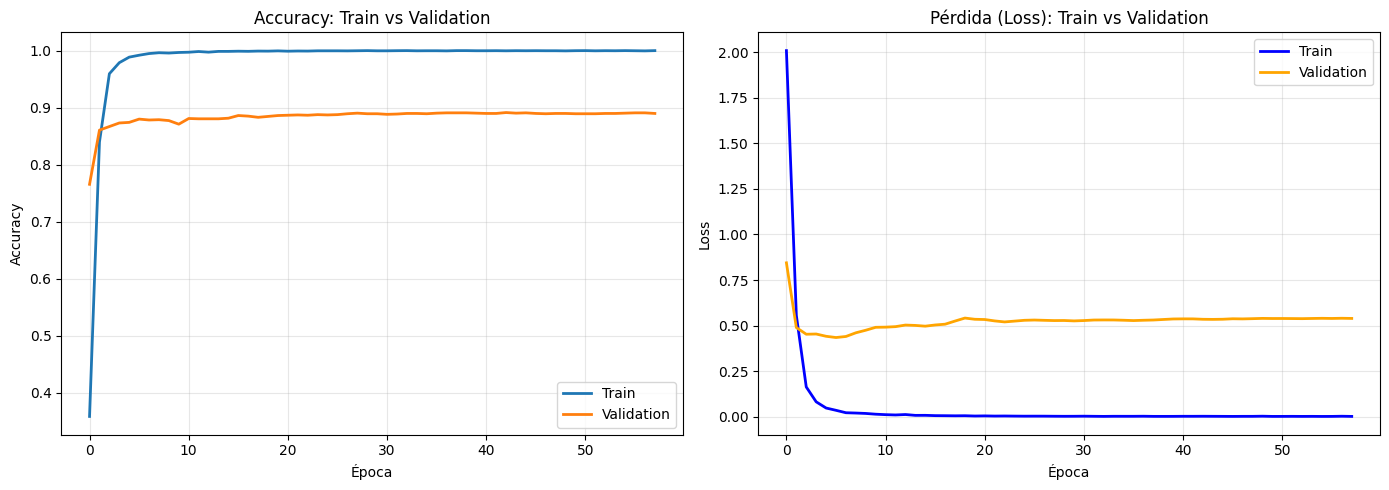

In [56]:
# Visualización de curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'],     label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Accuracy: Train vs Validation')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'],     label='Train', linewidth=2, color='blue')
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2, color='orange')
axes[1].set_title('Pérdida (Loss): Train vs Validation')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_entrenamiento.png', dpi=150, bbox_inches='tight')
plt.show()

# Resultados finales de entrenamiento
best_train_acc = max(history.history['accuracy'])
best_val_acc   = max(history.history['val_accuracy'])

RESULTADOS Y TEST DE VALIDACION

In [59]:
import random

# Predicción de un paciente aleatorio del test
idx     = random.randint(0, X_test_scaled.shape[0] - 1)
muestra = X_test_scaled[idx].reshape(1, -1)

probabilidades = model.predict(muestra)[0]
diagnostico    = np.argmax(probabilidades)

print(f'Paciente índice       : {idx}')
print(f'Diagnóstico real      : {label_encoder.classes_[y_test[idx]]}')
print(f'Diagnóstico predicho  : {label_encoder.classes_[diagnostico]}')
print(f'Probabilidades por clase:')
for i, p in enumerate(probabilidades):
    print(f'  Clase {label_encoder.classes_[i]}: {p*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Paciente índice       : 764
Diagnóstico real      : OBESIDAD, NO ESPECIFICADA
Diagnóstico predicho  : OBESIDAD, NO ESPECIFICADA
Probabilidades por clase:
  Clase CONSULTA PARA INSTRUCCION Y VIGILANCIA DE LA DIETA: 0.00%
  Clase HIPOTIROIDISMO, NO ESPECIFICADO: 0.00%
  Clase OBESIDAD DEBIDA A EXCESO DE CALORIAS: 0.00%
  Clase OBESIDAD EXTREMA CON HIPOVENTILACION ALVEOLAR: 0.00%
  Clase OBESIDAD INDUCIDA POR DROGAS: 0.00%
  Clase OBESIDAD, NO ESPECIFICADA: 100.00%
  Clase OTROS TIPOS DE OBESIDAD: 0.00%
  Clase OTROS TRASTORNOS DE LA GLANDULA HIPOFISIS: 0.00%
  Clase SOBREPESO: 0.00%
